# Feature selection and SHAP analysis

## Prepare data

In [24]:
import pandas as pd

In [25]:
categorical_cols = ["customer_zipcode", "library_city", "is_holiday_for_return", "checkout_dayofweek",]
numerical_cols = ["book_pages", "book_age", "customer_age","book_price"]

In [26]:
data = pd.read_csv("data/clean_merged_data.csv")
data = data[categorical_cols + numerical_cols + ["late_return"]]

In [27]:
data.head()

,customer_zipcode,library_city,is_holiday_for_return,checkout_dayofweek,book_pages,book_age,customer_age,book_price,late_return
0,972020.0,Portland,False,1,752,19.0,60.0,416.99,0
1,972120.0,unknown,False,4,790,21.0,62.0,217.00,1
2,972170.0,Portland,False,2,561,28.0,41.0,414.50,0
3,972120.0,Portland,False,5,530,31.0,49.0,149.00,0
4,972060.0,unknown,False,1,684,101.0,58.0,432.50,0


In [28]:
X = data[categorical_cols+numerical_cols]
y = data['late_return']

### Train the logistic regression and gradient boostg models to extract features from

In [29]:
from sklearn.impute import KNNImputer
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler

target_column = "late_return"
label_encoders = {}
for col in data.select_dtypes(include=['object']).columns:
    if col != target_column:  # Don't encode the target column if it's categorical
        le = LabelEncoder()
        data[col] = le.fit_transform(data[col])
        label_encoders[col] = le

X = data.drop(columns=[target_column])
y = data[target_column]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

imputer = KNNImputer(n_neighbors=5)
X_train_imputed = imputer.fit_transform(X_train)
X_test_imputed = imputer.transform(X_test)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_imputed)
X_test_scaled = scaler.transform(X_test_imputed)

# Train Gradient Boosting model
model_gb = GradientBoostingClassifier(n_estimators=100, random_state=42)
model_gb.fit(X_train_scaled, y_train)

# Train Logistic Regression model
model_lr = LogisticRegression()
model_lr.fit(X_train_scaled, y_train)

y_pred_gb = model_gb.predict(X_test_scaled)

accuracy = accuracy_score(y_test, y_pred_gb)
print(f"Accuracy: {accuracy:.2f}")
print("Classification Report:\n", classification_report(y_test, y_pred_gb))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_gb))

Accuracy: 0.91
Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.96      0.95       223
           1       0.43      0.30      0.35        20

    accuracy                           0.91       243
   macro avg       0.68      0.63      0.65       243
weighted avg       0.90      0.91      0.90       243

Confusion Matrix:
 [[215   8]
 [ 14   6]]


## Anova f regression feature selection

In [30]:
from utils.feature_selection import feature_selection_anova

In [31]:
anova_features = feature_selection_anova(X, y)

In [32]:
anova_features

[('book_pages', np.float64(59.80122404941782)),
 ('book_price', np.float64(21.53434818723289)),
 ('customer_zipcode', np.float64(6.724256055332482)),
 ('is_holiday_for_return', np.float64(5.793079922027288)),
 ('checkout_dayofweek', np.float64(4.130522621245025)),
 ('library_city', np.float64(1.626129990207494)),
 ('customer_age', np.float64(0.627808066012194)),
 ('book_age', np.float64(0.03931299165285364))]

## Extract feature importance from trained model

In [33]:
from utils.feature_selection import get_sorted_feature_importance_lr

In [34]:
get_sorted_feature_importance_lr(model_lr, feature_names=X.columns)

,Feature,Importance
4,book_pages,0.682345
0,customer_zipcode,0.184481
6,customer_age,0.158558
2,is_holiday_for_return,0.104558
1,library_city,0.102773
5,book_age,0.092988
7,book_price,0.070222
3,checkout_dayofweek,-0.029291


## RFE Sort features

In [35]:
X_train_df = pd.DataFrame(X_train_scaled)
X_train_df.columns = X.columns

In [36]:
from utils.feature_selection import feature_selection_rfe
rfe_features = feature_selection_rfe(X_train_df, y_train)

In [37]:
rfe_features

,Feature,Ranking
0,customer_zipcode,1
1,library_city,2
4,book_pages,3
3,checkout_dayofweek,4
6,customer_age,5
2,is_holiday_for_return,6
7,book_price,7
5,book_age,8


## SHAP

In [38]:
from utils.shap_stats import ShapStats

In [39]:
X = X.dropna()
X.fillna(0, inplace=True) 

In [40]:
stats = ShapStats(model_lr, X_train_scaled, feature_names=X.columns)

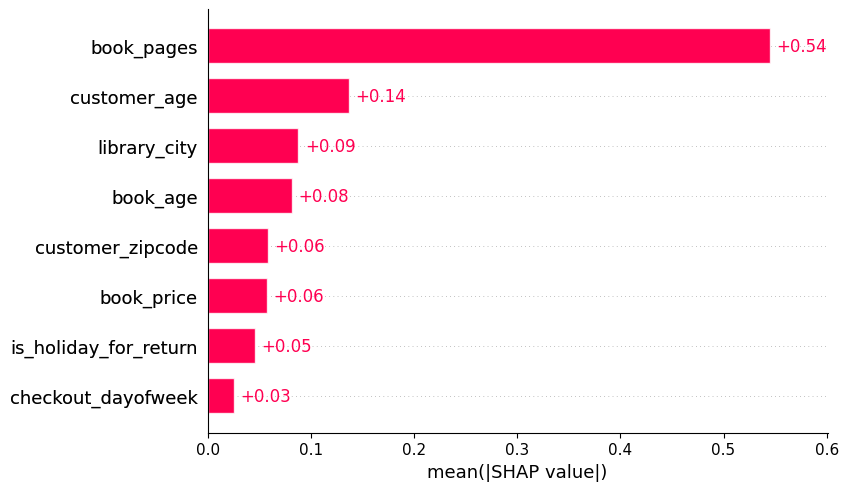

In [41]:
stats.global_bar()

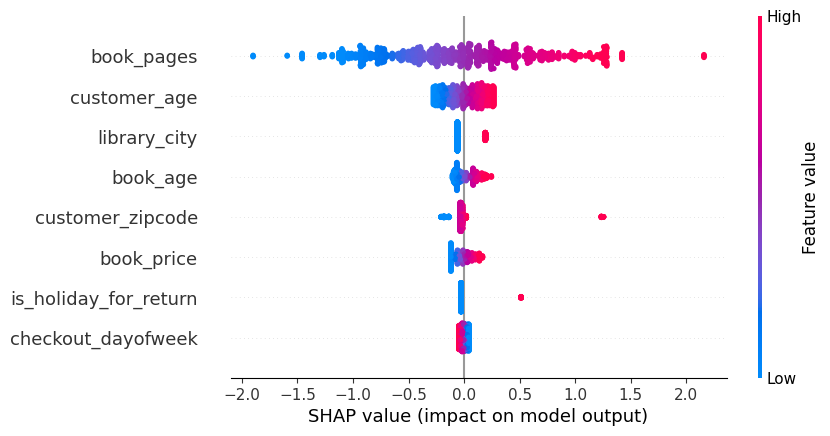

In [42]:
stats.beeswarm()